<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [21]</a>'.</span>

# Circuit

> SAX Circuits

In [1]:
import gdsfactory as gf
from gdsfactory.gpdk import PDK

import sax
from sax.circuits import (
    _create_dag,
    _find_leaves,
    _find_root,
    _flat_circuit,
    _validate_models,
    draw_dag,
)

PDK.activate()

Let's start by creating a simple recursive netlist with gdsfactory.


```{note}
We are using gdsfactory to create our netlist because it allows us to see the circuit we want to simulate and because we're striving to have a compatible netlist implementation in SAX.
 
 However... gdsfactory is not a dependency of SAX. You can also define your circuits by hand (see SAX Quick Start Notebook) or you can use another tool to programmatically construct your netlists.
 ```

In [2]:
@gf.cell
def mzi(delta_length=10.0):
    c = gf.Component()

    # components
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight(length=delta_length / 2.0)

    # references
    mmi_in = c.add_ref(mmi_in, name="mmi_in")
    mmi_out = c.add_ref(mmi_out, name="mmi_out")
    straight_top1 = c.add_ref(half_delay_straight, name="straight_top1")
    straight_top2 = c.add_ref(half_delay_straight, name="straight_top2")
    bend_top1 = c.add_ref(bend, name="bend_top1")
    bend_top2 = c.add_ref(bend, name="bend_top2").dmirror()
    bend_top3 = c.add_ref(bend, name="bend_top3").dmirror()
    bend_top4 = c.add_ref(bend, name="bend_top4")
    bend_btm1 = c.add_ref(bend, name="bend_btm1").dmirror()
    bend_btm2 = c.add_ref(bend, name="bend_btm2")
    bend_btm3 = c.add_ref(bend, name="bend_btm3")
    bend_btm4 = c.add_ref(bend, name="bend_btm4").dmirror()

    # connections
    bend_top1.connect("o1", mmi_in.ports["o2"])
    straight_top1.connect("o1", bend_top1.ports["o2"])
    bend_top2.connect("o1", straight_top1.ports["o2"])
    bend_top3.connect("o1", bend_top2.ports["o2"])
    straight_top2.connect("o1", bend_top3.ports["o2"])
    bend_top4.connect("o1", straight_top2.ports["o2"])

    bend_btm1.connect("o1", mmi_in.ports["o3"])
    bend_btm2.connect("o1", bend_btm1.ports["o2"])
    bend_btm3.connect("o1", bend_btm2.ports["o2"])
    bend_btm4.connect("o1", bend_btm3.ports["o2"])

    mmi_out.connect("o1", bend_btm4.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in.ports["o1"],
    )
    c.add_port("o2", port=mmi_out.ports["o3"])
    c.add_port("o3", port=mmi_out.ports["o4"])
    return c


@gf.cell
def twomzi():
    c = gf.Component()

    # instances
    mzi1 = mzi(delta_length=10)
    mzi2 = mzi(delta_length=20)

    # references
    mzi1_ = c.add_ref(mzi1, name="mzi1")
    mzi2_ = c.add_ref(mzi2, name="mzi2")

    # connections
    mzi2_.connect("o1", mzi1_.ports["o2"])

    # ports
    c.add_port("o1", port=mzi1_.ports["o1"])
    c.add_port("o2", port=mzi2_.ports["o2"])
    return c

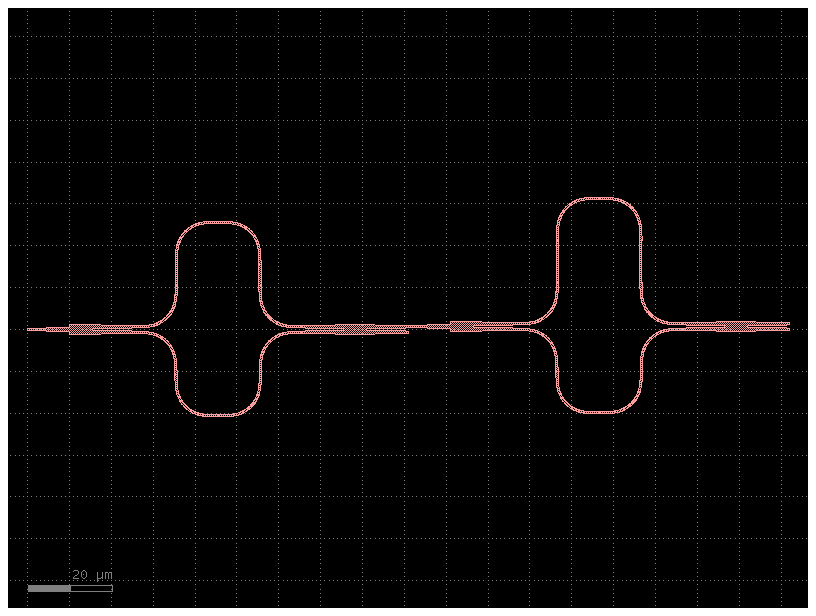

In [3]:
comp = twomzi()
comp

In [4]:
recnet = sax.netlist(comp.get_netlist(recursive=True))
mzi1_comp = recnet["twomzi"]["instances"]["mzi1"]["component"]
flatnet = recnet[mzi1_comp]

/home/flaport/Projects/sax2/.venv/lib/python3.14/site-packages/gdsfactory/component.py:508: UserWarning: Unconnected ports: ['mzi1,o3', 'mzi2,o3']
  return get_netlist_recursive(


To be able to model this device we'll need some SAX dummy models:

In [5]:
def bend_euler(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return sax.reciprocal({("o1", "o2"): 1.0})

In [6]:
def mmi1x2(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.45**0.5,
            ("o1", "o3"): 0.45**0.5,
        }
    )

In [7]:
def mmi2x2(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1", "o3"): 0.45**0.5,
            ("o1", "o4"): 1j * 0.45**0.5,
            ("o2", "o3"): 1j * 0.45**0.5,
            ("o2", "o4"): 0.45**0.5,
        }
    )

In [8]:
def straight(
    length=0.01,
    # npoints=2,
    # with_bbox=True,
    # cross_section=...
):
    return sax.reciprocal({("o1", "o2"): 1.0})

In SAX, we usually aggregate the available models in a models dictionary:

In [9]:
models = {
    "straight": straight,
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
}

We can also create some dummy multimode models:

In [10]:
def bend_euler_mm(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return sax.reciprocal(
        {
            ("o1@TE", "o2@TE"): 0.9**0.5,
            # ('o1@TE', 'o2@TM'): 0.01**0.5,
            # ('o1@TM', 'o2@TE'): 0.01**0.5,
            ("o1@TM", "o2@TM"): 0.8**0.5,
        }
    )

In [11]:
def mmi1x2_mm(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1@TE", "o2@TE"): 0.45**0.5,
            ("o1@TE", "o3@TE"): 0.45**0.5,
            ("o1@TM", "o2@TM"): 0.41**0.5,
            ("o1@TM", "o3@TM"): 0.41**0.5,
            ("o1@TE", "o2@TM"): 0.01**0.5,
            ("o1@TM", "o2@TE"): 0.01**0.5,
            ("o1@TE", "o3@TM"): 0.02**0.5,
            ("o1@TM", "o3@TE"): 0.02**0.5,
        }
    )

In [12]:
def mmi2x2_mm(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1@TE", "o3@TE"): 0.45**0.5,
            ("o1@TE", "o4@TE"): 1j * 0.45**0.5,
            ("o2@TE", "o3@TE"): 1j * 0.45**0.5,
            ("o2@TE", "o4@TE"): 0.45**0.5,
            ("o1@TM", "o3@TM"): 0.45**0.5,
            ("o1@TM", "o4@TM"): 1j * 0.45**0.5,
            ("o2@TM", "o3@TM"): 1j * 0.45**0.5,
            ("o2@TM", "o4@TM"): 0.45**0.5,
        }
    )

In [13]:
def straight_mm(
    length=0.01,
    # npoints=2,
    # with_bbox=True,
    # cross_section=...
):
    return sax.reciprocal(
        {
            ("o1@TE", "o2@TE"): 1.0,
            ("o1@TM", "o2@TM"): 1.0,
        }
    )

In [14]:
models_mm = {
    "straight": straight_mm,
    "bend_euler": bend_euler_mm,
    "mmi1x2": mmi1x2_mm,
    "mmi2x2": mmi2x2_mm,
}

We can now represent our recursive netlist model as a Directed Acyclic Graph:

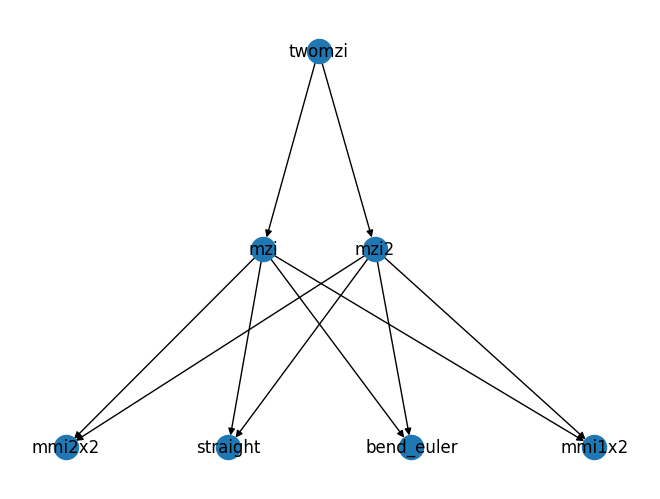

In [15]:
dag = _create_dag(recnet, models)
draw_dag(dag)

Note that the DAG depends on the models we supply. We could for example stub one of the sub-netlists by a pre-defined model:

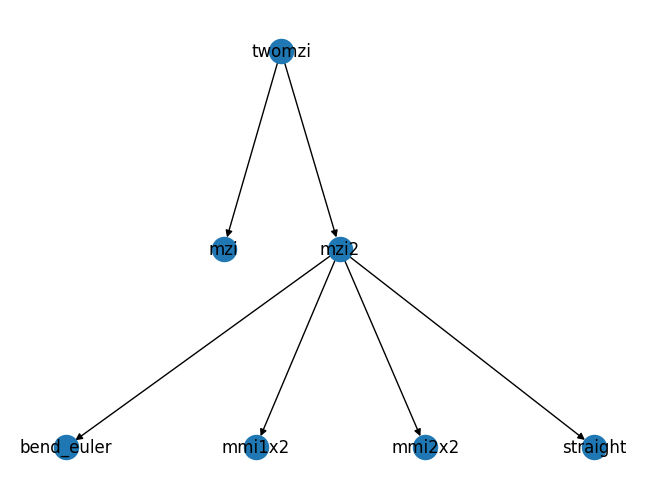

In [16]:
dag2 = _create_dag(recnet, {**models, mzi1_comp: mmi2x2})
draw_dag(dag2, with_labels=True)

This is useful if we for example pre-calculated a certain model.

We can easily find the root of the DAG:

In [17]:
_find_root(dag)

['twomzi']

Similarly we can find the leaves:

In [18]:
_find_leaves(dag)

['bend_euler', 'mmi1x2', 'mmi2x2', 'straight']

To be able to simulate the circuit, we need to supply a model for each of the leaves in the dependency DAG. Let's write a validator that checks this

In [19]:
models

{'straight': <function __main__.straight(length=0.01)>,
 'bend_euler': <function __main__.bend_euler(angle=90.0, p=0.5)>,
 'mmi1x2': <function __main__.mmi1x2(width=0.5, width_taper=1.0, length_taper=10.0, length_mmi=5.5, width_mmi=2.5, gap_mmi=0.25)>,
 'mmi2x2': <function __main__.mmi2x2(width=0.5, width_taper=1.0, length_taper=10.0, length_mmi=5.5, width_mmi=2.5, gap_mmi=0.25)>}

In [20]:
models = _validate_models(models, dag)

We can now dow a bottom-up simulation. Since at the bottom of the DAG, our circuit is always flat (i.e. not hierarchical) we can implement a minimal `_flat_circuit` definition, which only needs to work on a flat (non-hierarchical circuit):

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [21]:
from sax.netlists import convert_nets_to_connections

flatnet = convert_nets_to_connections(recnet[mzi1_comp])

single_mzi = _flat_circuit(
    flatnet["instances"],
    flatnet["connections"],
    flatnet.get("nets", []),
    flatnet["ports"],
    {},
    models,
    "klu",
)
single_mzi()

AttributeError: module 'klujax' has no attribute 'analyze'

The resulting circuit is just another SAX model (i.e. a python function) returing an SType:

In [ ]:
?single_mzi

Let's 'execute' the circuit:

Note that we can also supply multimode models:

In [ ]:
flatnet = recnet[mzi1_comp]
single_mzi = _flat_circuit(
    flatnet["instances"],
    flatnet.get("connections", {}),
    flatnet.get("nets", []),
    flatnet["ports"],
    {},
    models_mm,
    "klu",
)
single_mzi()

Now that we can handle flat circuits the extension to hierarchical circuits is not so difficult:

single mode simulation:

In [ ]:
double_mzi, info = sax.circuit(netlist=recnet, models=models, backend="default")
double_mzi()

multi mode simulation:

In [ ]:
double_mzi, info = sax.circuit(
    netlist=recnet, models=models_mm, backend="default", return_type="sdict"
)
double_mzi()

sometimes it's useful to get the required circuit model names to be able to create the circuit:

In [ ]:
sax.get_required_circuit_models(recnet, models)